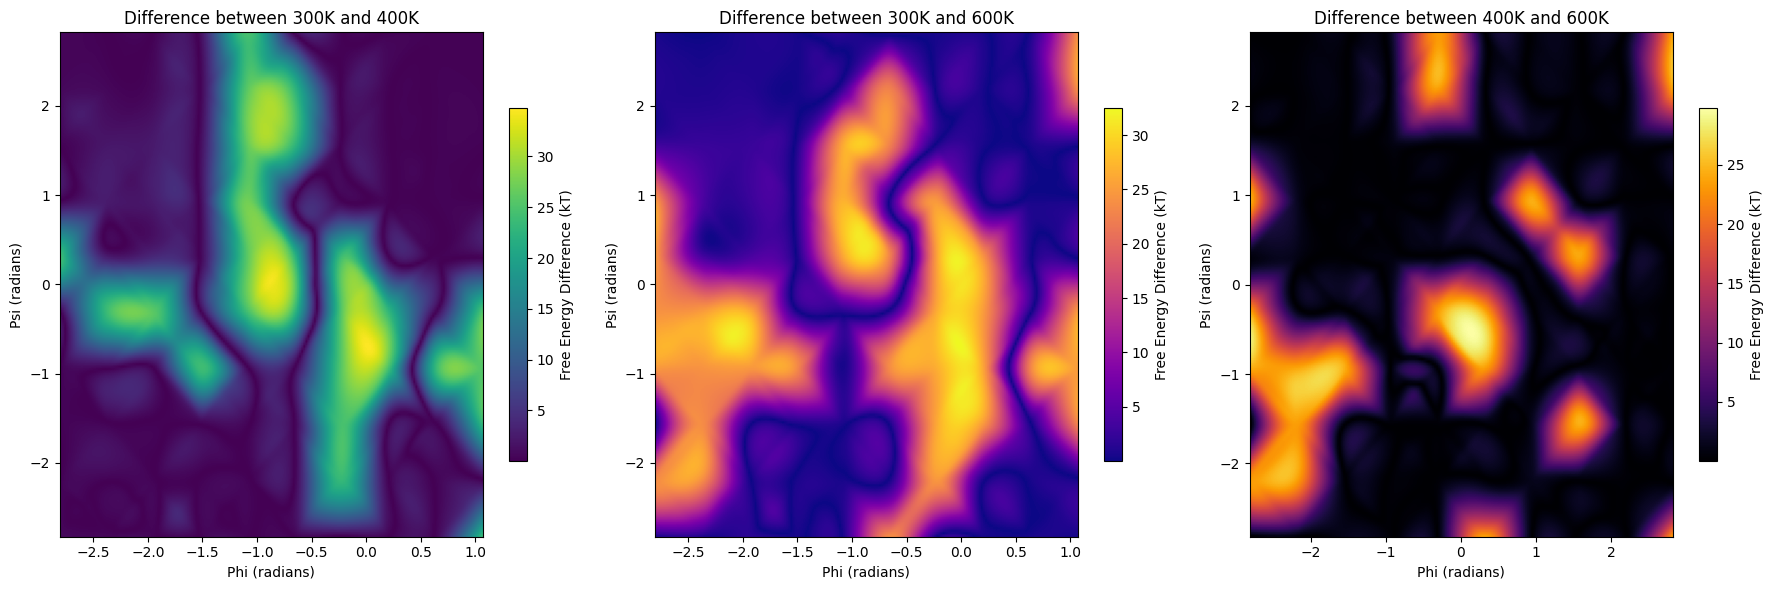

In [4]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import mdtraj as md
import numpy as np

# 加载不同温度下的轨迹文件
traj_300 = md.load('T300/adp_exchange3temps.xtc', top='T300/adp.gro')
traj_400 = md.load('T400/adp_exchange3temps.xtc', top='T400/adp.gro')
traj_600 = md.load('T600/adp_exchange3temps.xtc', top='T600/adp.gro')

# 计算 phi 和 psi 二面角
phi_300 = md.compute_phi(traj_300)[0]
psi_300 = md.compute_psi(traj_300)[0]
phi_400 = md.compute_phi(traj_400)[0]
psi_400 = md.compute_psi(traj_400)[0]
phi_600 = md.compute_phi(traj_600)[0]
psi_600 = md.compute_psi(traj_600)[0]

# 提取二面角值
phi_angles_300 = md.compute_dihedrals(traj_300, phi_300)
psi_angles_300 = md.compute_dihedrals(traj_300, psi_300)
phi_angles_400 = md.compute_dihedrals(traj_400, phi_400)
psi_angles_400 = md.compute_dihedrals(traj_400, psi_400)
phi_angles_600 = md.compute_dihedrals(traj_600, phi_600)
psi_angles_600 = md.compute_dihedrals(traj_600, psi_600)


def compute_fes(phi_angles, psi_angles, bins=10, fes_max=60):
    # 计算二维直方图
    hist, x_edges, y_edges = np.histogram2d(phi_angles.flatten(), psi_angles.flatten(), bins=bins)
    fes = -np.log(hist + 1e-10)  # 计算自由能
    fes -= np.min(fes)  # 使最小值为零
    
    # 限制自由能的最大值
    fes = np.clip(fes, None, fes_max)  # 设置自由能的最大值

    # 创建网格
    phi = (x_edges[:-1] + x_edges[1:]) / 2
    psi = (y_edges[:-1] + y_edges[1:]) / 2
    phi_grid, psi_grid = np.meshgrid(phi, psi)

    # 将二维数据插值到更高分辨率的网格上
    points = np.array([phi_grid.flatten(), psi_grid.flatten()]).T
    values = fes.T.flatten()
    phi_fine = np.linspace(phi.min(), phi.max(), 200)
    psi_fine = np.linspace(psi.min(), psi.max(), 200)
    phi_fine_grid, psi_fine_grid = np.meshgrid(phi_fine, psi_fine)
    fes_fine = griddata(points, values, (phi_fine_grid, psi_fine_grid), method='cubic')

    return phi_fine_grid, psi_fine_grid, fes_fine

# 计算每个温度下的自由能面
phi_grid_300, psi_grid_300, fes_300 = compute_fes(phi_angles_300, psi_angles_300)
phi_grid_400, psi_grid_400, fes_400 = compute_fes(phi_angles_400, psi_angles_400)
phi_grid_600, psi_grid_600, fes_600 = compute_fes(phi_angles_600, psi_angles_600)

def compute_difference(fes1, fes2):
    """计算两个自由能面之间的绝对差值"""
    return np.abs(fes1 - fes2)

# 计算自由能面的差异
fes_diff_300_400 = compute_difference(fes_300, fes_400)
fes_diff_300_600 = compute_difference(fes_300, fes_600)
fes_diff_400_600 = compute_difference(fes_400, fes_600)

# 创建一个图形对象来展示差异
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 300K vs 400K
im1 = axs[0].imshow(fes_diff_300_400, extent=[phi_grid_300.min(), phi_grid_300.max(), psi_grid_300.min(), psi_grid_300.max()],
                    origin='lower', cmap='viridis', aspect='auto')
axs[0].set_title('Difference between 300K and 400K')
axs[0].set_xlabel('Phi (radians)')
axs[0].set_ylabel('Psi (radians)')
fig.colorbar(im1, ax=axs[0], shrink=0.7, label='Free Energy Difference (kT)')

# 300K vs 600K
im2 = axs[1].imshow(fes_diff_300_600, extent=[phi_grid_300.min(), phi_grid_300.max(), psi_grid_300.min(), psi_grid_300.max()],
                    origin='lower', cmap='plasma', aspect='auto')
axs[1].set_title('Difference between 300K and 600K')
axs[1].set_xlabel('Phi (radians)')
axs[1].set_ylabel('Psi (radians)')
fig.colorbar(im2, ax=axs[1], shrink=0.7, label='Free Energy Difference (kT)')

# 400K vs 600K
im3 = axs[2].imshow(fes_diff_400_600, extent=[phi_grid_400.min(), phi_grid_400.max(), psi_grid_400.min(), psi_grid_400.max()],
                    origin='lower', cmap='inferno', aspect='auto')
axs[2].set_title('Difference between 400K and 600K')
axs[2].set_xlabel('Phi (radians)')
axs[2].set_ylabel('Psi (radians)')
fig.colorbar(im3, ax=axs[2], shrink=0.7, label='Free Energy Difference (kT)')

plt.tight_layout()
plt.show()
